# Medical Dataset Classification: Can you predict heart diseases?

## Импорты

In [16]:
import numpy as np
import pandas as pd
import scipy.stats as st

import textwrap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

import optuna
import joblib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import FeatureSpace
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import save_model, load_model, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

## Загрузка датасета

In [17]:
df = pd.read_csv('train.csv')
df.head()

ID        age  sex     chest  resting_blood_pressure  serum_cholestoral  \
0   0  49.207124    0  4.000000              162.996167         181.108682   
1   1  53.628425    1  1.741596              130.233730         276.474630   
2   2  49.591426    1  4.000000              146.999012         223.300517   
3   3  58.991445    1  4.000000              112.369143         187.245501   
4   4  51.053602    1  1.954609              138.032047         238.482868   

   fasting_blood_sugar  resting_electrocardiographic_results  \
0                    0                                     0   
1                    0                                     2   
2                    1                                     2   
3                    0                                     0   
4                    0                                     0   

   maximum_heart_rate_achieved  exercise_induced_angina   oldpeak  slope  \
0                   148.227858                        1  0.944547      2   
1                   152.917139                        0  0.119070      2   
2                   102.352090                        1  1.616747      2   
3                   158.164750                        1  0.000000      1   
4                   172.540828                        0  1.150464      1   

   number_of_major_vessels  thal  class  
0                        0     3      1  
1                        0     3      0  
2                        2     7      1  
3                        1     7      1  
4                        1     3      0

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 15 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ID                                    600000 non-null  int64  
 1   age                                   600000 non-null  float64
 2   sex                                   600000 non-null  int64  
 3   chest                                 600000 non-null  float64
 4   resting_blood_pressure                600000 non-null  float64
 5   serum_cholestoral                     600000 non-null  float64
 6   fasting_blood_sugar                   600000 non-null  int64  
 7   resting_electrocardiographic_results  600000 non-null  int64  
 8   maximum_heart_rate_achieved           600000 non-null  float64
 9   exercise_induced_angina               600000 non-null  int64  
 10  oldpeak                               600000 non-null  float64
 11  

Данные загружены. Пропусков нет. ID - неинформативный признак, удаляем.

In [19]:
df = df.drop('ID', axis=1)

In [20]:
df.duplicated().sum()

0

Явных дубликатов нет.

## Разведочный анализ данных и их очистка

In [21]:
df.describe()

age            sex          chest  resting_blood_pressure  \
count  600000.000000  600000.000000  600000.000000           600000.000000   
mean       54.426085       0.677447       3.170247              131.340485   
std         9.086041       0.467454       0.949618               17.842450   
min        26.061695       0.000000      -0.538498               82.918527   
25%        48.078493       0.000000       3.000000              119.924094   
50%        55.133425       1.000000       3.000000              129.727941   
75%        60.663775       1.000000       4.000000              139.915216   
max        79.591647       1.000000       4.000000              209.673650   

       serum_cholestoral  fasting_blood_sugar  \
count      600000.000000        600000.000000   
mean          249.592420             0.150757   
std            51.699976             0.357812   
min            98.326263             0.000000   
25%           216.475964             0.000000   
50%           244.233699             0.000000   
75%           274.345453             0.000000   
max           527.755764             1.000000   

       resting_electrocardiographic_results  maximum_heart_rate_achieved  \
count                         600000.000000                600000.000000   
mean                               1.020148                   149.592069   
std                                0.994204                    23.072593   
min                                0.000000                    61.844168   
25%                                0.000000                   135.704237   
50%                                2.000000                   153.224828   
75%                                2.000000                   165.165497   
max                                2.000000                   208.735196   

       exercise_induced_angina        oldpeak          slope  \
count            600000.000000  600000.000000  600000.000000   
mean                  0.333502       1.051391       1.596033   
std                   0.471464       1.144288       0.629821   
min                   0.000000      -0.806788       1.000000   
25%                   0.000000       0.000000       1.000000   
50%                   0.000000       0.811101       2.000000   
75%                   1.000000       1.674081       2.000000   
max                   1.000000       6.803372       3.000000   

       number_of_major_vessels           thal          class  
count            600000.000000  600000.000000  600000.000000  
mean                  0.681303       4.711378       0.444185  
std                   0.950669       1.934766       0.496875  
min                   0.000000       3.000000       0.000000  
25%                   0.000000       3.000000       0.000000  
50%                   0.000000       3.000000       0.000000  
75%                   1.000000       7.000000       1.000000  
max                   3.000000       7.000000       1.000000

Имеем дело с бинарной классификацией, категориальные данные закодированы с помощью порядкового кодирования - для деревьев и ансамблей то что надо, но не для логистической регрессии и искуственной нейронной сети. Для них необходимо OHE кодирование - можем осуществить далее в пайплайнах обучения. Проанлизируем признаки и таргет.

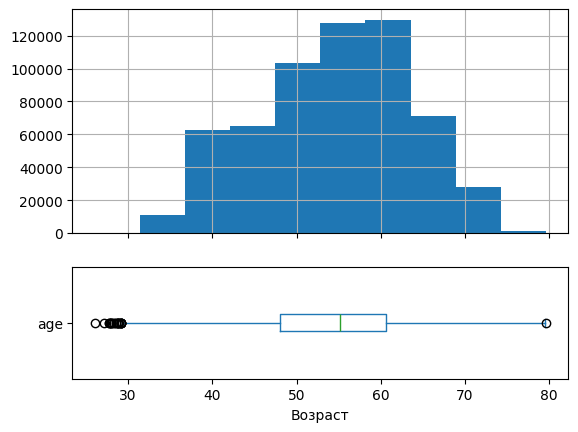

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,height_ratios=(2, 1))
df["age"].hist(ax=ax1);
df["age"].plot.box(ax=ax2, vert=False);
ax2.set_xlabel("Возраст");

Основная масса пациентов в возрасте от 30-40 до 70 лет.

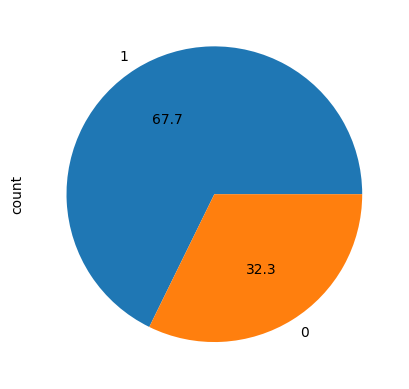

In [23]:
df["sex"].value_counts().plot.pie(autopct='%.1f');

Пациенты распределены неравномерно по полу. Так как данных о кодировании нет, скорее всего у мужчин (1) заболевания сердца встречается чаще по выборке.

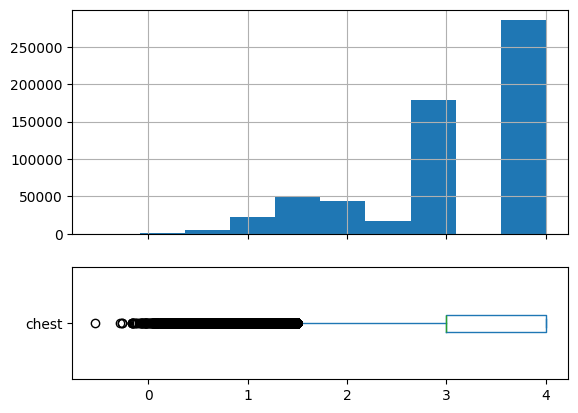

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,height_ratios=(2, 1))
df["chest"].hist(ax=ax1);
df["chest"].plot.box(ax=ax2, vert=False);

Изначально это картегориальная переменная с 4 значениями. Но в этом датасете она относится к числовым. Отрицательные значения врят ли возможны поэтому заменяем их на 0.

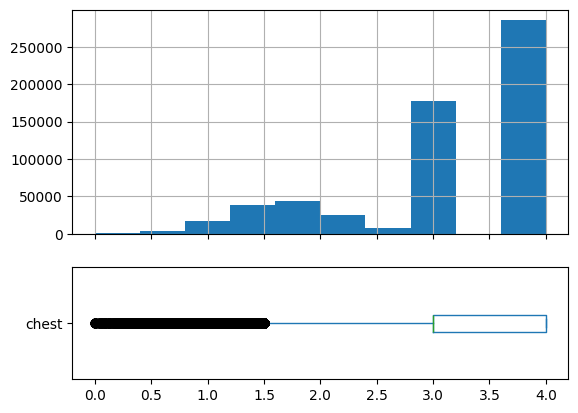

In [25]:
df["chest"] = df["chest"].apply(lambda x: x if x>=0 else 0)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,height_ratios=(2, 1))
df["chest"].hist(ax=ax1);
df["chest"].plot.box(ax=ax2, vert=False);

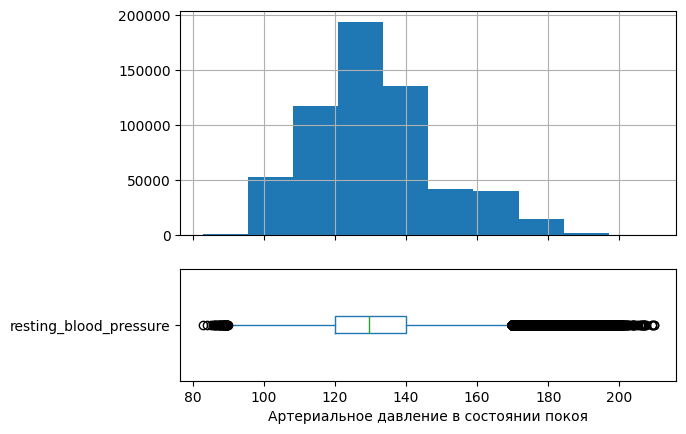

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,height_ratios=(2, 1))
df["resting_blood_pressure"].hist(ax=ax1);
df["resting_blood_pressure"].plot.box(ax=ax2, vert=False);
ax2.set_xlabel("Артериальное давление в состоянии покоя");


У основной массы пациентов кровяное давление в покое (систолическое) соотвествует норме или легкой гипертензии. Статистические выбросы выше 170 мм. рт. ст. впринципе вполне реальны и соответствуют тяжелой гипертензии.

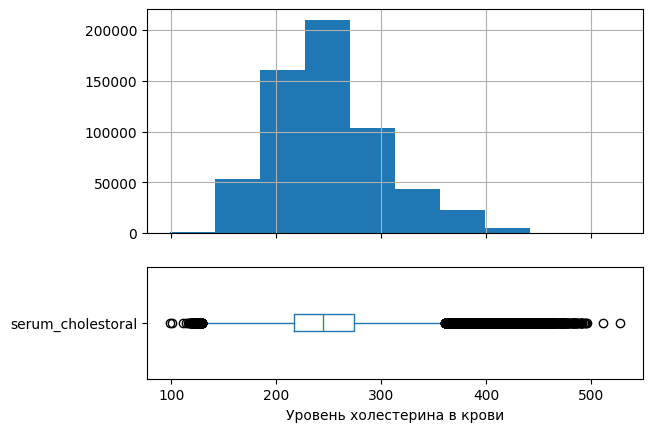

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,height_ratios=(2, 1))
df["serum_cholestoral"].hist(ax=ax1);
df["serum_cholestoral"].plot.box(ax=ax2, vert=False);
ax2.set_xlabel("Уровень холестерина в крови");

У большинства он повышен (>200 мг/дл). Есть и те у кого он сильно повышен. Это впринципе очень характерно, учитывая образ жизни большинства населения развитых стран.

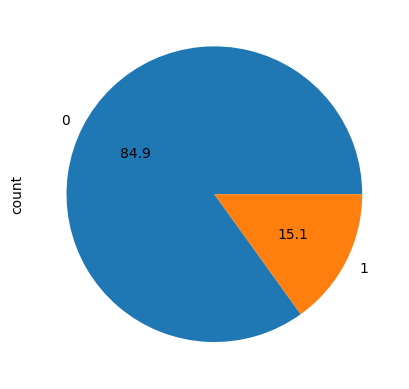

In [28]:
df["fasting_blood_sugar"].value_counts().plot.pie(autopct='%.1f');

У 15% содержание глюкозы в крови натощак > 120 мг/дл

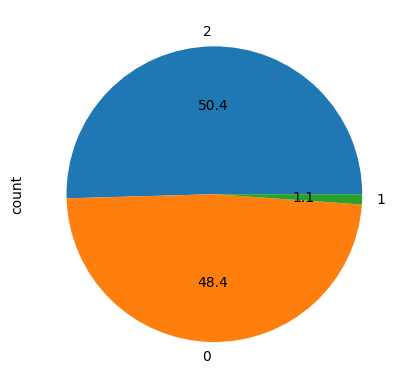

In [29]:
df["resting_electrocardiographic_results"].value_counts().plot.pie(autopct='%.1f');

Три класса: класс 1 - исчезающе мал, остальные 2 распределены поровну.

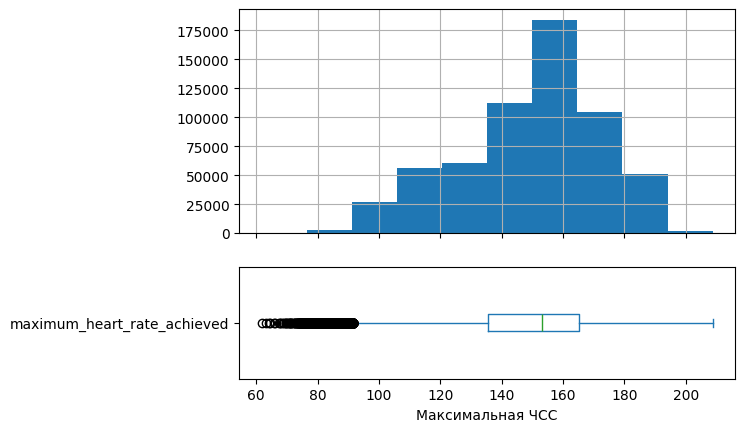

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,height_ratios=(2, 1))
df["maximum_heart_rate_achieved"].hist(ax=ax1);
df["maximum_heart_rate_achieved"].plot.box(ax=ax2, vert=False);
ax2.set_xlabel("Максимальная ЧСС");


Без соотнесения с нагрузкой при которой они мерялись - судить о норме тяжело.

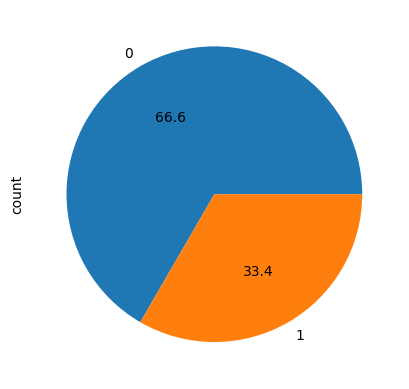

In [31]:
df["exercise_induced_angina"].value_counts().plot.pie(autopct='%.1f');

У 33% пациентов наблюдается стенокардия при нагрузке.

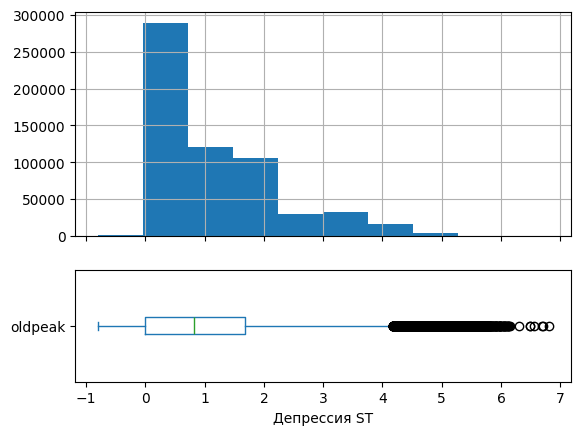

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,height_ratios=(2, 1))
df["oldpeak"].hist(ax=ax1);
df["oldpeak"].plot.box(ax=ax2, vert=False);
ax2.set_xlabel("Депрессия ST");


Отрицательные значения скорее всего ошибки, но их немного и они небольшие - заменяем на 0.

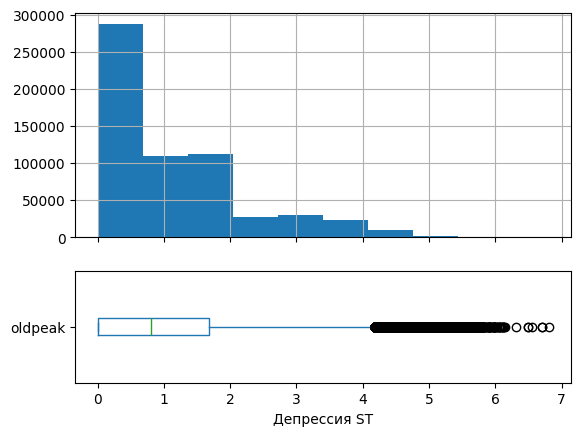

In [33]:
df["oldpeak"] = df["oldpeak"].apply(lambda x: x if x>=0 else 0)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,height_ratios=(2, 1))
df["oldpeak"].hist(ax=ax1);
df["oldpeak"].plot.box(ax=ax2, vert=False);
ax2.set_xlabel("Депрессия ST");

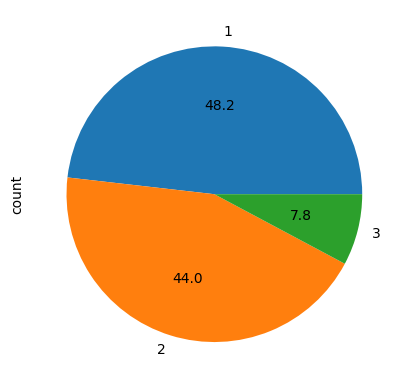

In [34]:
df["slope"].value_counts().plot.pie(autopct='%.1f');

Категориальная переменная - три категории.

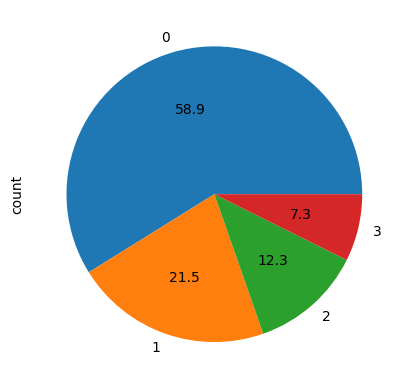

In [35]:
df["number_of_major_vessels"].value_counts().plot.pie(autopct='%.1f');

Числовая дискретная переменная (0-3). У большинство пациентов 0.

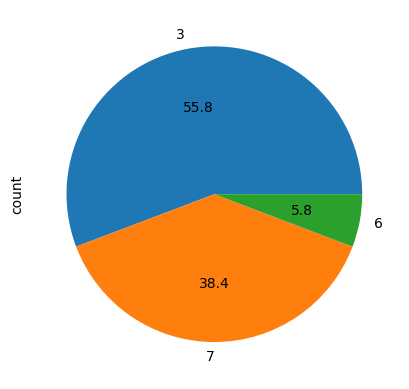

In [36]:
df["thal"].value_counts().plot.pie(autopct='%.1f');

Три категории. Для моделей на деревьев можно использовать как есть.

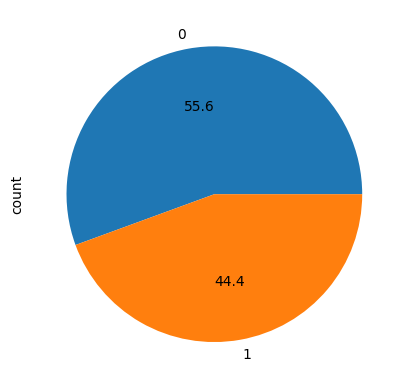

In [37]:
df["class"].value_counts().plot.pie(autopct='%.1f');

Совсем небольшой дисбаланс классов. Методов борьбы с дисбалансом и стратификации не требуется. В качестве целевой метрики можно использовать accurancy. В качестве дополнительной - auc-roc.

## Корреляционный анализ
Для выполнения классического корреляционного анализа необходимо выполнить преобразование переменных в фиктивные для категориальных переменных.

In [38]:
multiclass_columns = ["resting_electrocardiographic_results", "slope", "thal"]
df_dummy = pd.get_dummies(df, columns=multiclass_columns,  dtype=float)

In [39]:
df_dummy.head()

age  sex     chest  resting_blood_pressure  serum_cholestoral  \
0  49.207124    0  4.000000              162.996167         181.108682   
1  53.628425    1  1.741596              130.233730         276.474630   
2  49.591426    1  4.000000              146.999012         223.300517   
3  58.991445    1  4.000000              112.369143         187.245501   
4  51.053602    1  1.954609              138.032047         238.482868   

   fasting_blood_sugar  maximum_heart_rate_achieved  exercise_induced_angina  \
0                    0                   148.227858                        1   
1                    0                   152.917139                        0   
2                    1                   102.352090                        1   
3                    0                   158.164750                        1   
4                    0                   172.540828                        0   

    oldpeak  number_of_major_vessels  class  \
0  0.944547                        0      1   
1  0.119070                        0      0   
2  1.616747                        2      1   
3  0.000000                        1      1   
4  1.150464                        1      0   

   resting_electrocardiographic_results_0  \
0                                     1.0   
1                                     0.0   
2                                     0.0   
3                                     1.0   
4                                     1.0   

   resting_electrocardiographic_results_1  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     0.0   

   resting_electrocardiographic_results_2  slope_1  slope_2  slope_3  thal_3  \
0                                     0.0      0.0      1.0      0.0     1.0   
1                                     1.0      0.0      1.0      0.0     1.0   
2                                     1.0      0.0      1.0      0.0     0.0   
3                                     0.0      1.0      0.0      0.0     0.0   
4                                     0.0      1.0      0.0      0.0     1.0   

   thal_6  thal_7  
0     0.0     0.0  
1     0.0     0.0  
2     0.0     1.0  
3     0.0     1.0  
4     0.0     0.0

### Диаграмма рассеяния

Для диаграммы рассеяния очень большой датасет. Возьмём случайно 5% данных. Ограничимся бинарными и числовыми данными для диаграммы рассеяния.

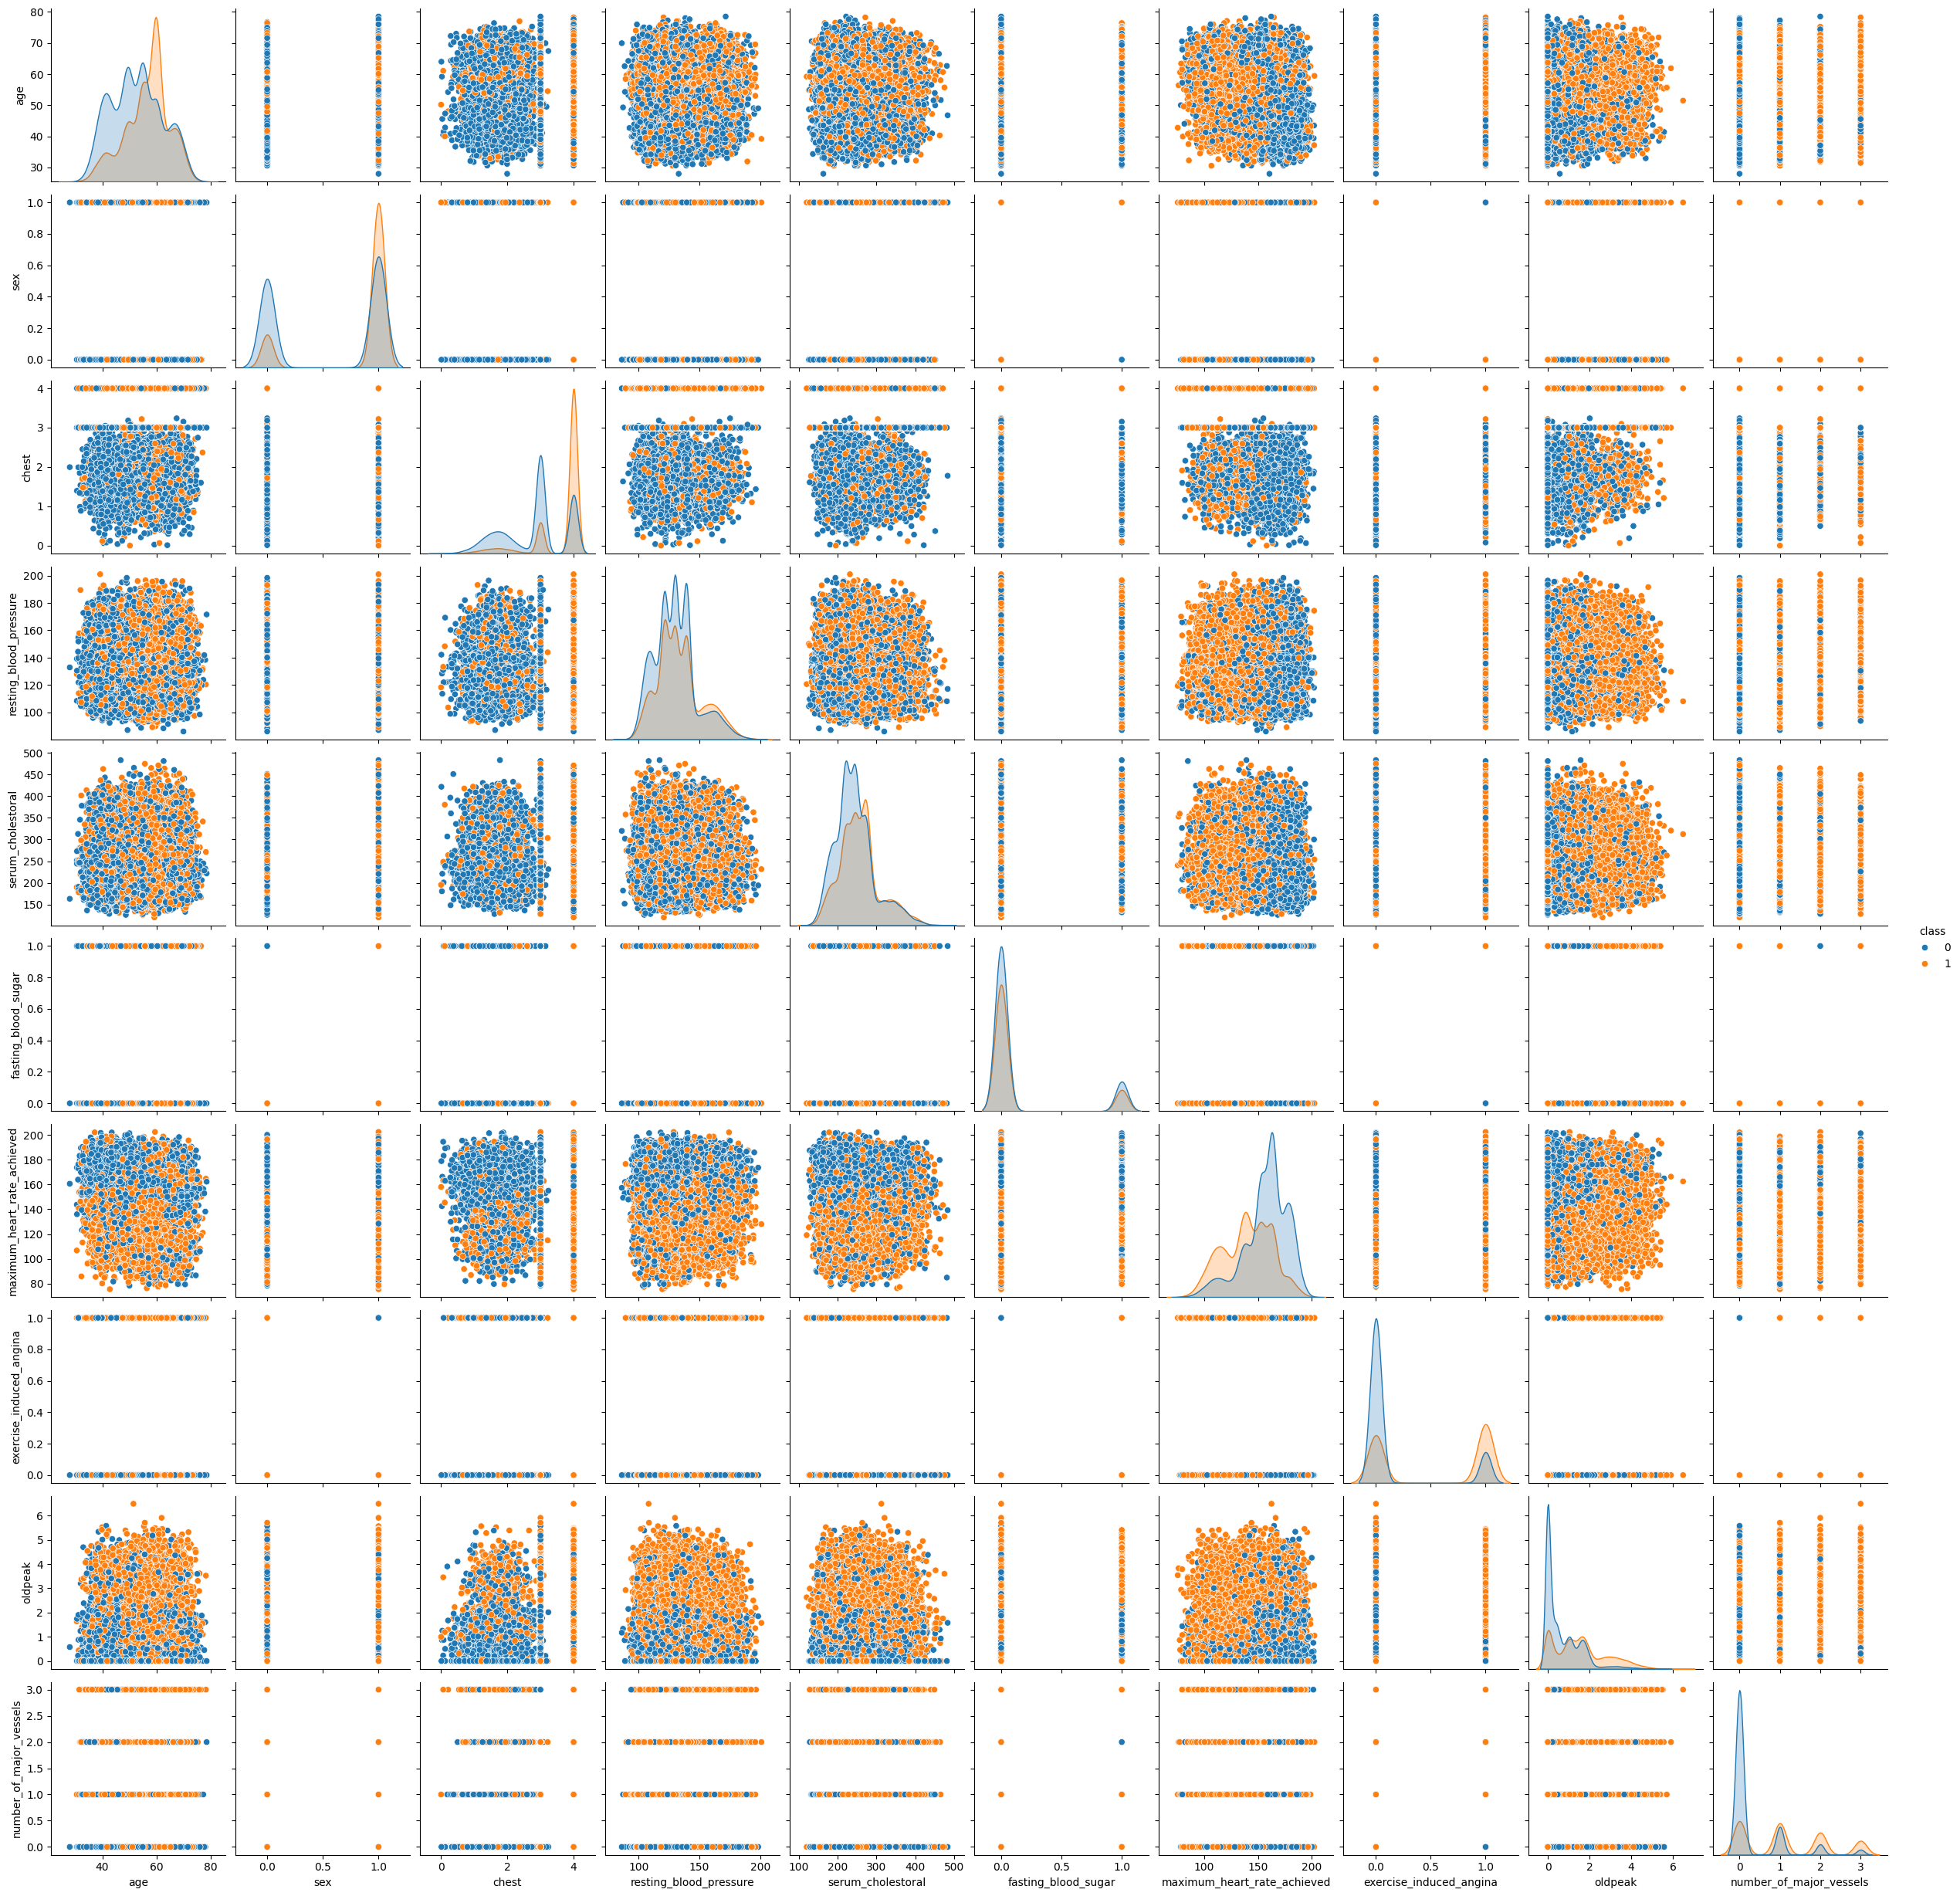

In [40]:
sns.pairplot(df_dummy.iloc[:,:11].sample(frac=0.05, random_state=42), hue='class');

### Матрица корреляций (тепловая карта)

In [45]:
def corr_matrix_with_pval(df, method = 'pearson', figsize=(20, 20), title=None):
  """
  df: dataframe to be used. Ensured the dataframe has been sliced to contain only the column you need. It accepts only numerical columns
  method: default uses the pearson method. It overall permits 3 methods; 'pearson', 'spearman' and 'kendall'
  figsize: default is (20, 10) but you can change it based on your preference
  title: Specify the title for your chart, default is None
  """

  data = df.copy()
  # Применяем метод corr() для рассчета корреляции между переменными
  corr = data.corr(method = method)

  # Создаем маску, чтобы скрыть верхний треугольник
  mask = np.zeros_like(corr, dtype=bool)
  mask[np.triu_indices_from(mask)] = True

  # Устанавливаем для диагональных элементов значение False, чтобы отобразить самокорреляцию
  np.fill_diagonal(mask, False)

  fig, ax = plt.subplots(figsize=figsize)
  plt.title(title, fontsize=20)

  # Создаем тепловую карту с маской
  heatmap = sns.heatmap(corr,
                        annot=True,
                        annot_kws={"fontsize": 12},  # Adjust annotation font size
                        fmt='.2f',
                        linewidths=0.5,
                        cmap='RdBu',
                        mask=mask,
                        ax=ax)

  # Создаем функцию для рассчета p_values
  p_values = np.full((corr.shape[0], corr.shape[1]), np.nan)
  for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[1]):
      x = data.iloc[:, i]
      y = data.iloc[:, j]
      mask = ~np.logical_or(pd.isnull(x), pd.isnull(y))
      if np.sum(mask) > 0:
        if method == 'pearson':
          p_values[i, j] = st.pearsonr(x[mask], y[mask])[1] #Changes based on the method chosen in the function
        elif method == 'kendall':
          p_values[i, j] = st.kendalltau(x[mask], y[mask])[1]
        elif method == 'spearman':
          p_values[i, j] = st.spearmanr(x[mask], y[mask])[1]

  p_values = pd.DataFrame(p_values, columns=corr.columns, index=corr.index)

  # Создаем маску p_values для тепловой карты
  mask_pvalues = np.triu(np.ones_like(p_values), k=1)

  # Рассчитываем наибольший и наименьший коэффициенты корреляции
  max_corr = np.max(corr.max())
  min_corr = np.min(corr.min())

  # Аннотируем тепловую карту p_values, меняем цвет в зависимости от значения
  for i in range(p_values.shape[0]):
    for j in range(p_values.shape[1]):
      if mask_pvalues[i, j]:
        p_value = p_values.iloc[i, j]
        if not np.isnan(p_value):
          correlation_value = corr.iloc[i, j]
          text_color = 'white' if correlation_value >= (max_corr - 0.4) or correlation_value <= (min_corr + 0.4) else 'black'
          ax.text(i + 0.5, j + 0.8, f'({p_value:.2f})',
                  horizontalalignment='center',
                  verticalalignment='center',
                  fontsize=12,
                  color=text_color)

  # Настройка меток оси x
  x_labels = [textwrap.fill(label.get_text(), 19) for label in ax.get_xticklabels()]
  ax.set_xticklabels(x_labels, fontdict={"fontsize": 12}, rotation=90, ha="center")

  # Настройка меток оси y
  y_labels = [textwrap.fill(label.get_text(), 19) for label in ax.get_yticklabels()]
  ax.set_yticklabels(y_labels, fontdict={"fontsize": 12}, rotation=0, ha="right")
  plt.tight_layout()

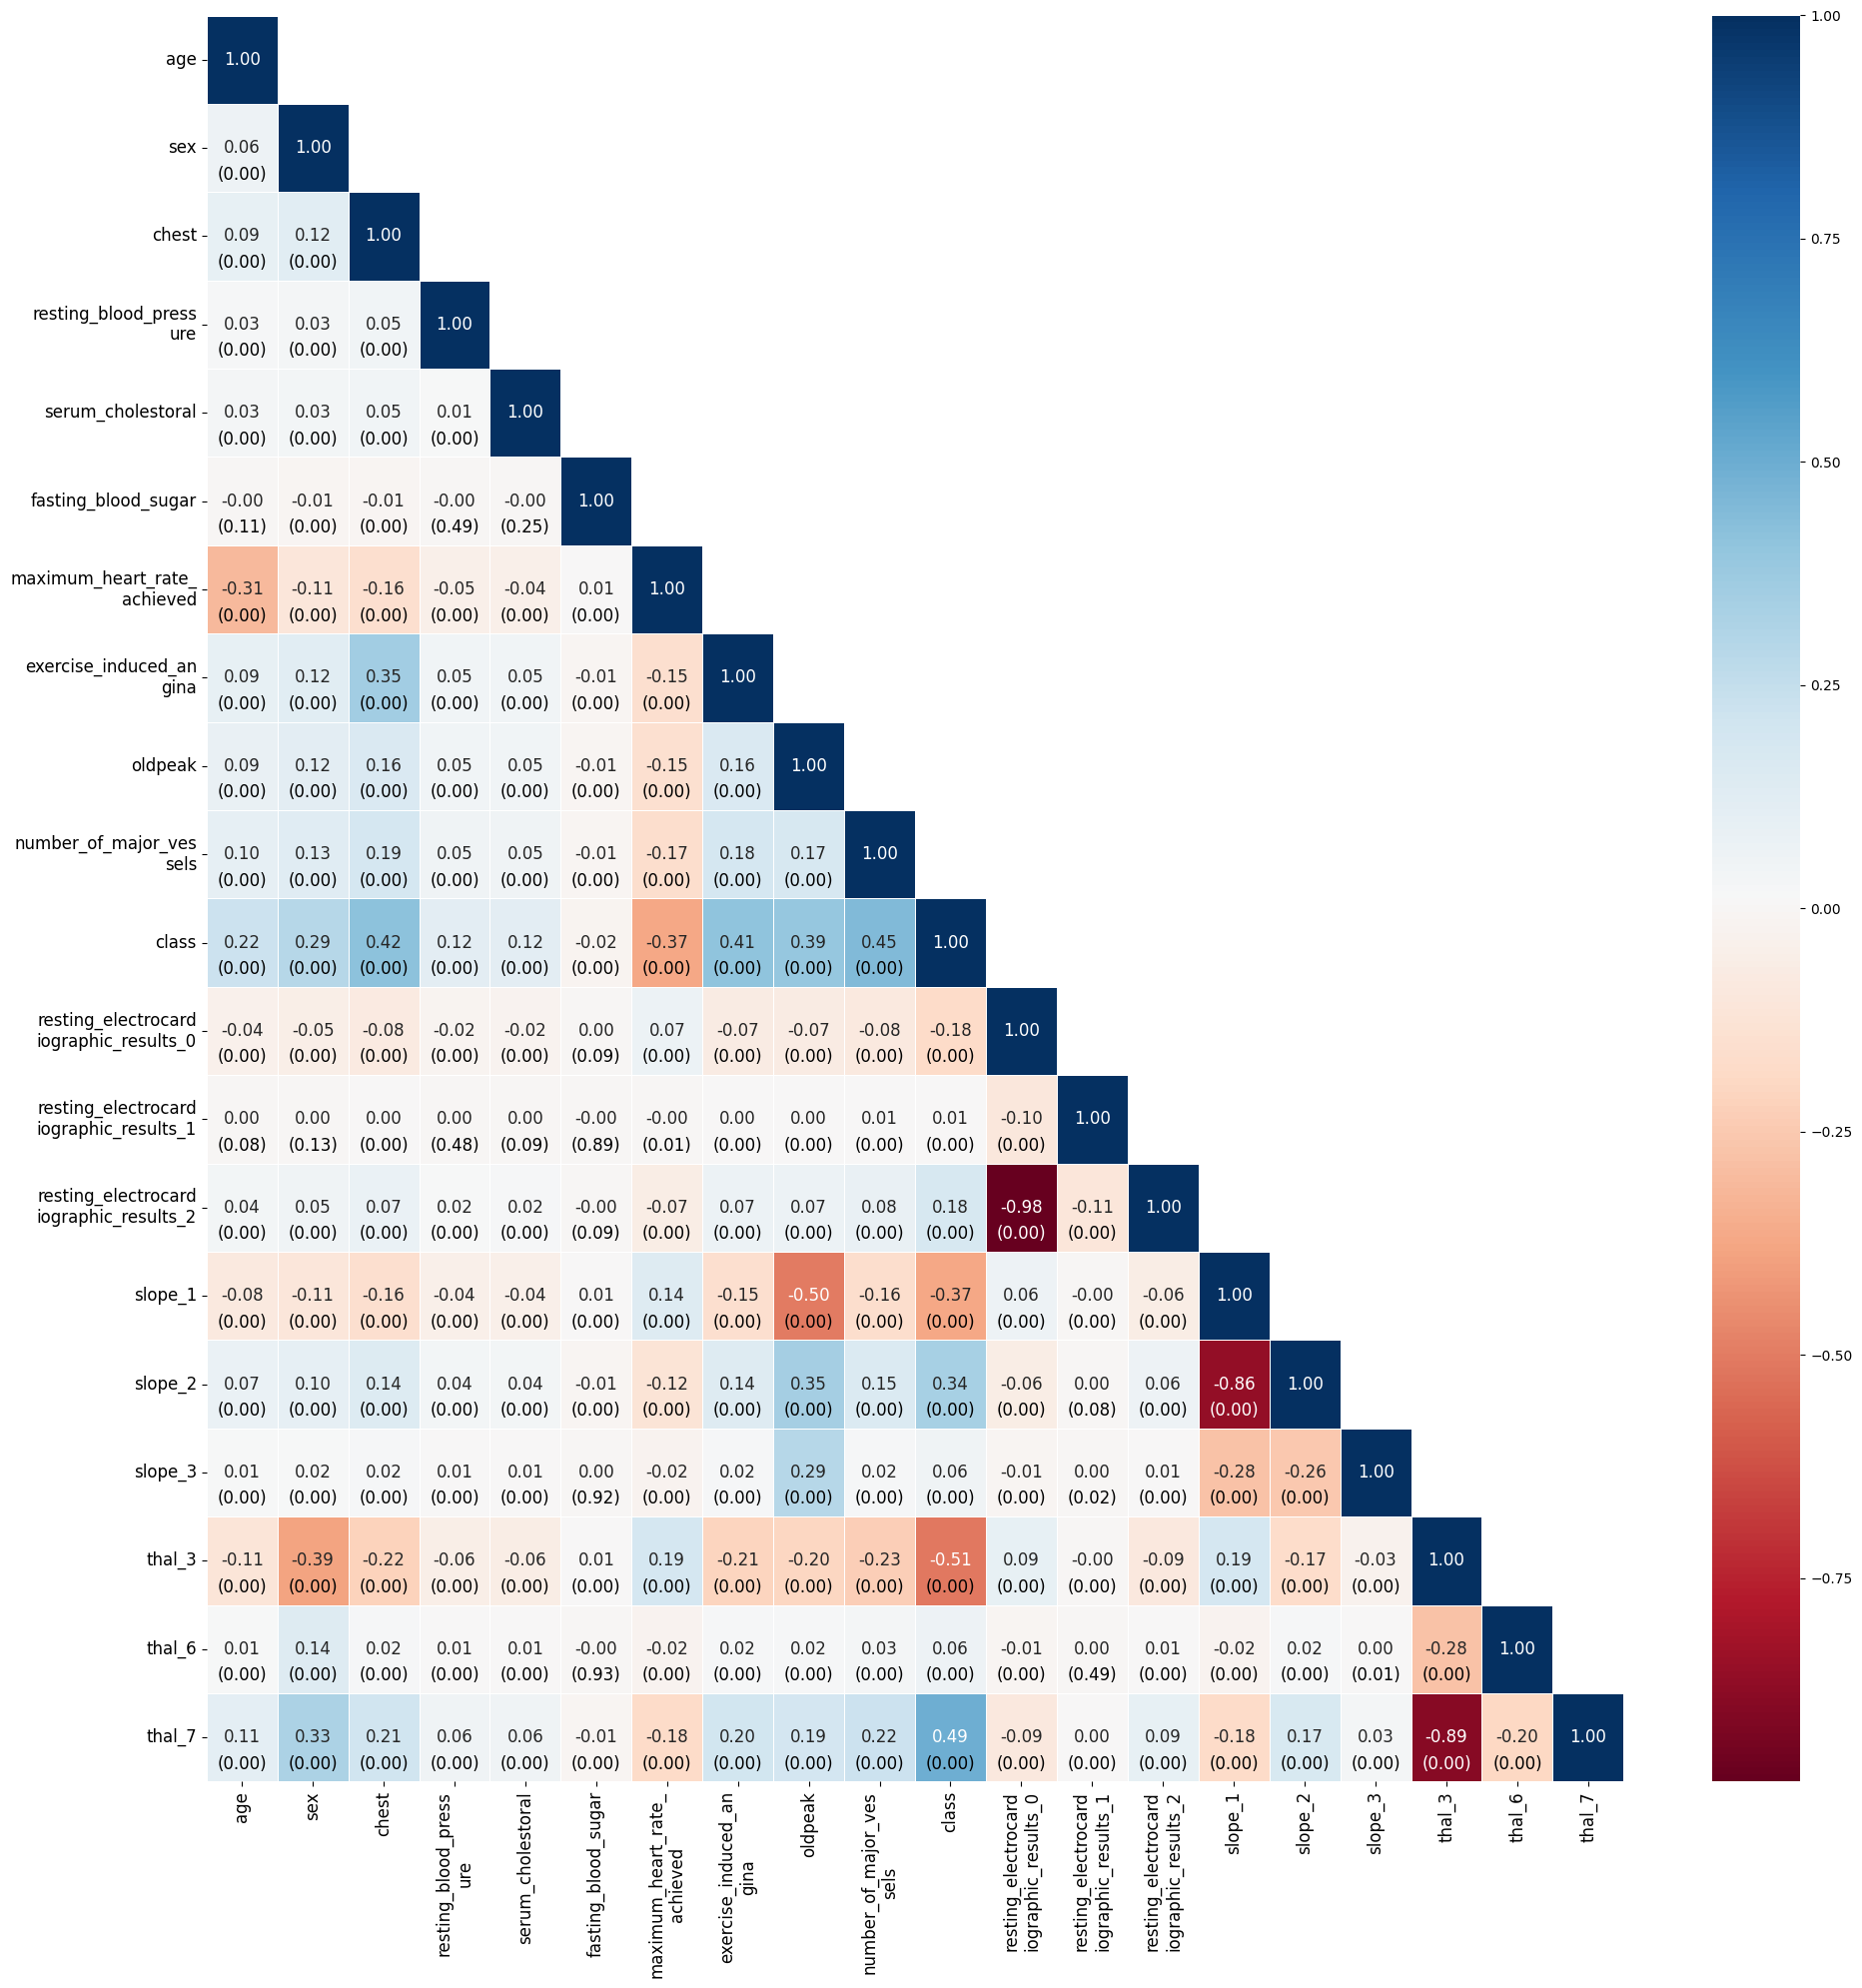

In [46]:
corr_matrix_with_pval(df_dummy)

С целевой переменной умеренно положительно коррелируют: chest, наличие боли в груди при нагрузке, депрессия ST-сегмента, число крупных сосудов, класс 2 наклона пикового сегмента ST, наличие дефектов. Отрицательно умеренно коррелирует: максимальная ЧСС при нагрузке, класс 1 наклона пикового сегмента, отсуттвие дефектов.

## Классическое машинное обучение
Делим данные на тест, валид, и трейн. Так как данных много можно разделить на трейн, валид и тест как 80:10:10. Однако GridSearchCV плохо поддерживает
 ручное деление на выборки, поэтому воспользуемся Optune для настройки гиперпараметров.

In [47]:
SEED = 42
df_train, df_test_val = train_test_split(df, test_size=0.2, random_state=SEED)
df_test, df_val = train_test_split(df_test_val, test_size=0.5, random_state=SEED)

Делим все выборки на фичи и таргет.

In [50]:
X_train, y_train = df_train.drop('class', axis=1), df_train["class"]
X_val, y_val = df_val.drop('class', axis=1), df_val["class"]
X_test, y_test = df_test.drop('class', axis=1), df_test["class"]

Модель логистической регрессии
Модель требует OHE-кодирования с избеганием Dummy-ловушки и масштабирования признаков. Подбирать будем степень регуляризации. Создадим Pipeline.


In [52]:
num_features = set(X_train.columns) - set(multiclass_columns)
preprocessor_lr = ColumnTransformer(transformers=[('num', StandardScaler(), list(num_features)),
                                                ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), multiclass_columns)])

In [53]:
def objective(trial):
    params = {
        'C' : trial.suggest_float("C", 1e-3, 1e1, log=True),
    }
    lr_pipeline = Pipeline(steps=[('p_linear', preprocessor_lr),
                                  ('logreg', LogisticRegression(**params, random_state=SEED, n_jobs=-1, max_iter=5000))])

    lr_pipeline.fit(X_train, y_train)
    score = lr_pipeline.score(X_val, y_val)
    return score

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50, n_jobs=-1)
print(f'The best params: {study.best_trial.params}')
print(f'The best accurancy: {study.best_value: .2%}')

[I 2024-10-05 14:18:39,580] A new study created in memory with name: no-name-fad0ea26-b0df-4cb3-b15a-660c77ac1c2d
[I 2024-10-05 14:18:52,217] Trial 1 finished with value: 0.882 and parameters: {'C': 0.0037907600653385803}. Best is trial 1 with value: 0.882.
[I 2024-10-05 14:18:52,272] Trial 2 finished with value: 0.8824833333333333 and parameters: {'C': 5.837289446988998}. Best is trial 2 with value: 0.8824833333333333.
[I 2024-10-05 14:18:52,397] Trial 3 finished with value: 0.8823333333333333 and parameters: {'C': 0.007338582410458984}. Best is trial 2 with value: 0.8824833333333333.
[I 2024-10-05 14:18:52,561] Trial 0 finished with value: 0.8824833333333333 and parameters: {'C': 1.6714295747743309}. Best is trial 2 with value: 0.8824833333333333.
[I 2024-10-05 14:18:57,630] Trial 4 finished with value: 0.8819 and parameters: {'C': 0.0021178824618578087}. Best is trial 2 with value: 0.8824833333333333.
[I 2024-10-05 14:18:59,070] Trial 5 finished with value: 0.8824666666666666 and pa

The best params: {'C': 5.837289446988998}
The best accurancy:  88.25%


Неплохая точность. Построим график коэффициентов модели, построив модель на выборке train+valid.

In [54]:
model_lr_tr_val = Pipeline(steps=[('p_linear', preprocessor_lr),
                                  ('logreg', LogisticRegression(C=study.best_params['C'], random_state=SEED, n_jobs=-1, max_iter=5000))])
X_train_val, y_train_val = pd.concat([X_train, X_val]), pd.concat([y_train, y_val])
model_lr_tr_val.fit(X_train_val, y_train_val)

Pipeline(steps=[('p_linear',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['maximum_heart_rate_achieved',
                                                   'sex', 'serum_cholestoral',
                                                   'chest',
                                                   'number_of_major_vessels',
                                                   'resting_blood_pressure',
                                                   'exercise_induced_angina',
                                                   'oldpeak',
                                                   'fasting_blood_sugar',
                                                   'age']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['resting_electrocardiographic_results',
                                                   'slope', 'thal'])])),
                ('logreg',
                 LogisticRegression(C=5.837289446988998, max_iter=5000,
                                    n_jobs=-1, random_state=42))])

In [55]:
pd.DataFrame(zip(model_lr_tr_val.steps[0][1].get_feature_names_out(),
                 np.transpose(model_lr_tr_val.steps[1][1].coef_)), columns=['features', 'coef']).sort_values(by='coef', ascending=False)

features                     coef
15                                  cat__thal_7     [2.1774586543283636]
14                                  cat__thal_6       [1.26295581665786]
12                                 cat__slope_2     [1.0982734656446778]
4                  num__number_of_major_vessels      [1.042018474355324]
3                                    num__chest     [0.7941447136674775]
11  cat__resting_electrocardiographic_results_2     [0.7383686110950407]
7                                  num__oldpeak     [0.7372492738577322]
6                  num__exercise_induced_angina     [0.6905721138683877]
10  cat__resting_electrocardiographic_results_1     [0.6003153090505953]
1                                      num__sex     [0.3383766942814916]
9                                      num__age    [0.28542530439650315]
2                        num__serum_cholestoral    [0.24370378408026253]
5                   num__resting_blood_pressure    [0.22862789669673195]
13                                 cat__slope_3    [0.15848189874062082]
8                      num__fasting_blood_sugar  [-0.028846187783132908]
0              num__maximum_heart_rate_achieved    [-0.7362095278847756]

В целом коэффициенты модели соответствуют результатам корреляционного анализа.

### Случайный лес
Для этой модели не обязательно ни создание фиктивных переменных, ни шкалирование признаков.

In [56]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 50)
    }
    rf = RandomForestClassifier(**params, random_state=SEED, n_jobs=-1)

    rf.fit(X_train, y_train)
    score = rf.score(X_val, y_val)
    return score

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50, n_jobs=1)
print(f'The best params: {study.best_trial.params}')
print(f'The best accurancy: {study.best_value: .2%}')

[I 2024-10-05 14:23:42,264] A new study created in memory with name: no-name-23c15ac5-46cd-4bde-b2bf-f79c1f54f0aa
[I 2024-10-05 14:26:34,039] Trial 0 finished with value: 0.898 and parameters: {'n_estimators': 145, 'max_depth': 26}. Best is trial 0 with value: 0.898.
[I 2024-10-05 14:30:46,469] Trial 1 finished with value: 0.8988 and parameters: {'n_estimators': 228, 'max_depth': 19}. Best is trial 1 with value: 0.8988.
[I 2024-10-05 14:37:33,465] Trial 2 finished with value: 0.89845 and parameters: {'n_estimators': 352, 'max_depth': 37}. Best is trial 1 with value: 0.8988.
[I 2024-10-05 14:45:04,419] Trial 3 finished with value: 0.8986166666666666 and parameters: {'n_estimators': 392, 'max_depth': 25}. Best is trial 1 with value: 0.8988.
[I 2024-10-05 14:50:18,999] Trial 4 finished with value: 0.8984333333333333 and parameters: {'n_estimators': 272, 'max_depth': 49}. Best is trial 1 with value: 0.8988.
[I 2024-10-05 14:53:27,382] Trial 5 finished with value: 0.89785 and parameters: {'

The best params: {'n_estimators': 338, 'max_depth': 13}
The best accurancy:  89.97%


Лучше, чем логистическая регрессия, но не намного, особенно при условии значительно возросшего времени обучения и тестирования.
Оценим важность признаков

In [57]:
model_rf_tr_val = RandomForestClassifier(**study.best_trial.params, random_state=SEED, n_jobs=-1)
model_rf_tr_val.fit(X_train_val, y_train_val)

RandomForestClassifier(max_depth=13, n_estimators=338, n_jobs=-1,
                       random_state=42)

Здесь не показан знак влияния, однако это ещё один способ оценки влияния признаков на целевую переменную.

## Глубокое обучение

Определим функцию для преобразования датасета в тензорный тип.

In [70]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("class")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe),seed=SEED)
    return ds


train_ds = dataframe_to_dataset(df_train)
val_ds = dataframe_to_dataset(df_val)

Зададим размер батча.

In [71]:
train_ds = train_ds.batch(1024)
val_ds = val_ds.batch(1024)

In [72]:
df_train.columns

Index(['age', 'sex', 'chest', 'resting_blood_pressure', 'serum_cholestoral',
       'fasting_blood_sugar', 'resting_electrocardiographic_results',
       'maximum_heart_rate_achieved', 'exercise_induced_angina', 'oldpeak',
       'slope', 'number_of_major_vessels', 'thal', 'class'],
      dtype='object')

In [73]:
multiclass_columns

['resting_electrocardiographic_results', 'slope', 'thal']

Настроим преобразование данных.

In [74]:
feature_space = FeatureSpace(
    features={
        'resting_electrocardiographic_results': "integer_categorical",
        "sex": "integer_categorical",
        "thal": "integer_categorical",
        "age": "float_discretized",
        'chest': "float_normalized",
        'resting_blood_pressure': "float_normalized",
        'serum_cholestoral':"float_normalized",
        'maximum_heart_rate_achieved': "float_normalized",
        'fasting_blood_sugar': 'integer_categorical',
        "exercise_induced_angina": 'integer_categorical',
         'oldpeak': "float_normalized",
        "number_of_major_vessels": "float_normalized",
        'slope': "integer_categorical"
    },
    output_mode="concat",
)

Обучим модуль преобразования признаков.

In [75]:
train_ds_with_no_labels = train_ds.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

Создадим предобработанные датасеты для загрузки в модель.

In [76]:
preprocessed_train_ds = train_ds.map(lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_train_ds = preprocessed_train_ds.prefetch(tf.data.AUTOTUNE)

preprocessed_val_ds = val_ds.map(lambda x, y: (feature_space(x), y), num_parallel_calls=tf.data.AUTOTUNE)
preprocessed_val_ds = preprocessed_val_ds.prefetch(tf.data.AUTOTUNE)

Определим 2 модели - одну для обучения другую для инференса.

In [77]:
dict_inputs = feature_space.get_inputs()
encoded_features = feature_space.get_encoded_features()

x = Dense(1024, activation="relu")(encoded_features)
x = BatchNormalization()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)
predictions = keras.layers.Dense(1, activation="sigmoid")(x)

training_model = keras.Model(inputs=encoded_features, outputs=predictions)
training_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

inference_model = keras.Model(inputs=dict_inputs, outputs=predictions)

In [78]:
training_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_46CLONE            │ (None, 59)             │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │        61,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 590,849 (2.25 MB)

 Trainable params: 588,801 (2.25 MB)

 Non-trainable params: 2,048 (8.00 KB)

Определим функции обратного вызова для остановки процесса обучения если оно зашло в тупик и сохранения лучшего результата.

In [80]:
callbacks_list = [
    EarlyStopping(
        monitor='val_loss',
        patience=3),
    ModelCheckpoint(
        filepath='my_model.keras',
        monitor='val_loss',
        save_best_only=True)
]
N_EPOCH = 20

Обучим модель с валидацией.

In [81]:
history = training_model.fit(
    preprocessed_train_ds,
    epochs=N_EPOCH,
    validation_data=preprocessed_val_ds,
    verbose=2,
    callbacks=callbacks_list
)

Epoch 1/20


469/469 - 102s - 218ms/step - accuracy: 0.8917 - loss: 0.2658 - val_accuracy: 0.8966 - val_loss: 0.2665
Epoch 2/20
469/469 - 98s - 209ms/step - accuracy: 0.8981 - loss: 0.2476 - val_accuracy: 0.8979 - val_loss: 0.2475
Epoch 3/20
469/469 - 98s - 209ms/step - accuracy: 0.8999 - loss: 0.2442 - val_accuracy: 0.8983 - val_loss: 0.2455
Epoch 4/20
469/469 - 97s - 207ms/step - accuracy: 0.9006 - loss: 0.2424 - val_accuracy: 0.8992 - val_loss: 0.2449
Epoch 5/20
469/469 - 97s - 207ms/step - accuracy: 0.9015 - loss: 0.2408 - val_accuracy: 0.8992 - val_loss: 0.2437
Epoch 6/20
469/469 - 97s - 206ms/step - accuracy: 0.9020 - loss: 0.2398 - val_accuracy: 0.8993 - val_loss: 0.2444
Epoch 7/20
469/469 - 94s - 201ms/step - accuracy: 0.9022 - loss: 0.2387 - val_accuracy: 0.8991 - val_loss: 0.2442
Epoch 8/20
469/469 - 92s - 197ms/step - accuracy: 0.9030 - loss: 0.2375 - val_accuracy: 0.8993 - val_loss: 0.2441


Визуализируем процесс обучения.

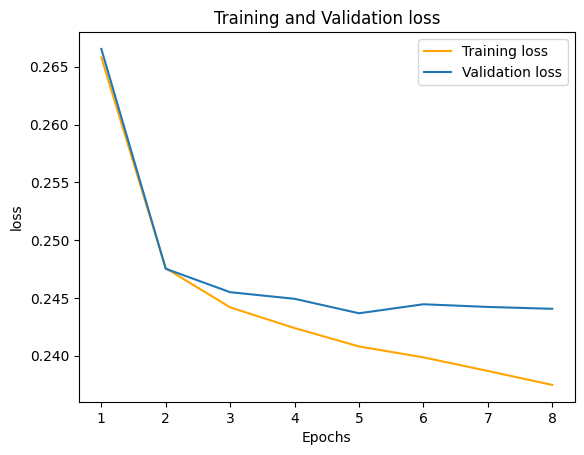

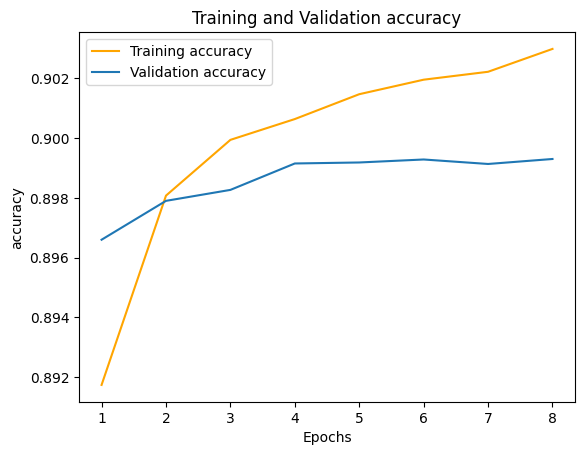

In [82]:
def check_metrics(history, figure_name):

    train = history.history[f'{figure_name}']
    val = history.history[f'val_{figure_name}']

    # Построение графика лосса и валидационного лосса
    epochs = range(1, len(train) + 1)
    plt.plot(epochs, train, label=f'Training {figure_name}', color='orange')
    plt.plot(epochs, val, label=f'Validation {figure_name}')
    plt.title(f'Training and Validation {figure_name}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{figure_name}')
    plt.legend()
    plt.show()

check_metrics(history, 'loss')
check_metrics(history, "accuracy")

Не намного отличается от случайного леса и логистической регрессии. Если брать по лучшему accurancy на валидации, то rf с настроенными параметрами показывет не намного, но лучший результат, однако проще в применении чем нейросеть.

## Тестирование лучшей модели на тестовой выборки.

In [87]:
print(f"Test accurancy: {model_rf_tr_val.score(X_test, y_test):.2%}")

Test accurancy: 89.73%


Примерно так же как на трэйне - переобучения нет. Построим матрицу ошибок.

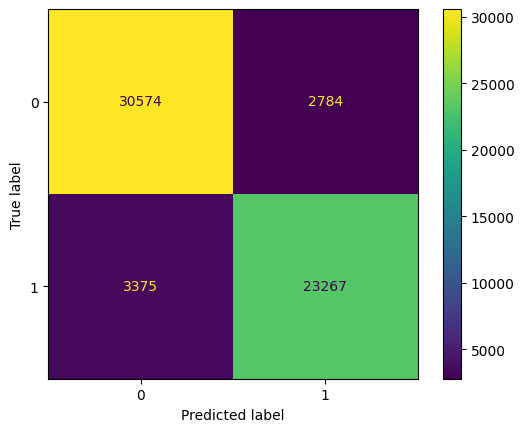

In [84]:
predictions = model_rf_tr_val.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=model_rf_tr_val.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_rf_tr_val.classes_)
disp.plot()
plt.show()

Ложно отрицательных результатов чуть больше, что не очень хорошо, но приемлемо. Впрочем это можно отрегулировать дополнительной калибровкой. Постоим дополнительно ROC-кривую.

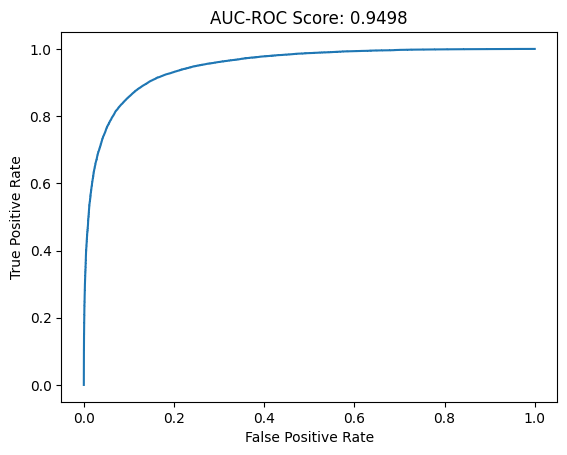

In [85]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    plt.title(f"AUC-ROC Score: {roc_auc_score(true_y, y_prob):.4f}")
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

y_prob = model_lr_tr_val.predict_proba(X_test)[:,1]
plot_roc_curve(y_test, y_prob)

Неплохо выглядит и кривая и само значение. Подготовим модель, дообучив её на тестовых данных и сохранив в файл.

In [86]:
X_all, y_all = df.drop("class", axis= 1), df["class"]

In [88]:
model_rf_all = RandomForestClassifier(**study.best_trial.params, random_state=SEED, n_jobs=-1)
model_rf_all.fit(X_all, y_all)

RandomForestClassifier(max_depth=13, n_estimators=338, n_jobs=-1,
                       random_state=42)

In [89]:
joblib.dump(model_rf_all, "rf.dump")

['rf.dump']

## Инференс
Загрузка модели.

In [90]:
model = joblib.load("rf.dump")

In [91]:
features={
    "age": int,
    "sex": int,
    'chest': float,
    'resting_blood_pressure': float,
    'serum_cholestoral':float,
    'fasting_blood_sugar': int,
    'resting_electrocardiographic_results': int,
    'maximum_heart_rate_achieved': float,
    "exercise_induced_angina": int,
    'oldpeak': float,
    'slope': int,
    "number_of_major_vessels": float,
    "thal": int
}

In [100]:
data_inf = {}
for f_name, tp in features.items():
    data_inf[f_name] = tp(input(f'Enter {f_name}: '))

In [101]:
df_inf = pd.Series(data_inf).to_frame().T
df_inf

age  sex  chest  resting_blood_pressure  serum_cholestoral  \
0  40.0  1.0    2.0                   148.0              120.0   

   fasting_blood_sugar  resting_electrocardiographic_results  \
0                  0.0                                   1.0   

   maximum_heart_rate_achieved  exercise_induced_angina  oldpeak  slope  \
0                        130.0                      1.0      0.5    1.0   

   number_of_major_vessels  thal  
0                      2.0   4.0

In [102]:
print(f'Heart deasease: {bool(model.predict(df_inf)[0])}, Prob (uncalibrated): {model.predict_proba(df_inf)[0][1]:.2%}')

Heart deasease: False, Prob (uncalibrated): 47.61%
